# Keane and Wolpin (1994)

*Note that most of the code cells are hidden from this notebook for a better reading flow. Check out the notebook in the documentation folder in the Github repository for more details.*

Keane and Wolpin (1994) and the previously published working paper Keane and Wolpin (1994b) generate three different Monte Carlo samples. This notebook replicates some of their results as well as giving other insights into the model.

## Some intuitions

We first plot the returns to experience while holding education constant at the initial ten years. Occupation B is more skill intensive in the sense that own experience has higher return than is the case for Occupation A. There is some general skill learned in Occupation A which is transferable to Occupation B. However, work experience is occupation-specific in Occupation B.

In [1]:
%matplotlib agg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import respy as rp
import warnings

from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.style.use("../_static/respy.mplstyle")

In [3]:
# Load example model and convert parameter and options to model attributes.
params, options = rp.get_example_model("kw_94_one", with_data=False)

In [4]:
ret_schooling_occ_a = params.loc[("wage_a", "exp_edu"), "value"]
ret_schooling_occ_b = params.loc[("wage_b", "exp_edu"), "value"]

ret_exp_a_occ_a = params.loc[("wage_a", "exp_a"), "value"]
ret_exp_a_sq_occ_a = params.loc[("wage_a", "exp_a_square"), "value"]
ret_exp_b_occ_a = params.loc[("wage_a", "exp_b"), "value"]
ret_exp_b_sq_occ_a = params.loc[("wage_a", "exp_b_square"), "value"]
log_rental_price_occ_a = params.loc[("wage_a", "constant"), "value"]

ret_exp_a_occ_b = params.loc[("wage_b", "exp_a"), "value"]
ret_exp_a_sq_occ_b = params.loc[("wage_b", "exp_a_square"), "value"]
ret_exp_b_occ_b = params.loc[("wage_b", "exp_b"), "value"]
ret_exp_b_sq_occ_b = params.loc[("wage_b", "exp_b_square"), "value"]
log_rental_price_occ_b = params.loc[("wage_b", "constant"), "value"]

In [5]:
x, y = np.meshgrid(range(0, 20), range(0, 20))

z_a = np.exp(
    log_rental_price_occ_a
    + ret_schooling_occ_a * 10
    + ret_exp_a_occ_a * x
    + ret_exp_a_sq_occ_a * x ** 2
    + ret_exp_b_occ_a * y
    + ret_exp_b_sq_occ_a * y ** 2
)

z_b = np.exp(
    log_rental_price_occ_b
    + ret_schooling_occ_b * 10
    + ret_exp_a_occ_b * x
    + ret_exp_a_sq_occ_b * x ** 2
    + ret_exp_b_occ_b * y
    + ret_exp_b_sq_occ_b * y ** 2
)

In [6]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax1.plot_surface(x, y, z_a / 1_000, cmap="Greens")
ax2.plot_surface(x, y, z_b / 1_000, cmap="Reds")

for ax in [ax1, ax2]:
    ax.set_xticks(range(0, 21, 5))
    ax.set_yticks(range(0, 21, 5))
    ax.set_zticks(range(10, 36, 5))
    ax.set_zticklabels(range(10, 36, 5))
    ax.set_zlim(10, 35)
    ax.invert_xaxis()
    ax.set_xlabel("Experience A")
    ax.set_ylabel("Experience B")
    ax.set_proj_type("ortho")
    ax.set_zlabel("Wages in (\$1,000)", labelpad=-1)

ax1.set_title("(a)", y=-0.15)
ax2.set_title("(b)", y=-0.15);

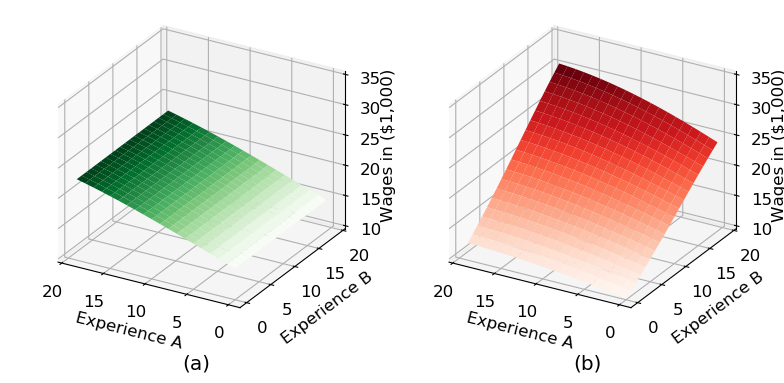

In [7]:
fig

The next figure shows that the returns to schooling are larger in Occupation B. While its initial wage is lower, it does increase faster with schooling compared to Occupation A. The graphs are generated by holding experience in both sectors constant at five years.

In [8]:
years_schooling = np.arange(10, 21)

wage_a = np.exp(
    log_rental_price_occ_a
    + ret_schooling_occ_a * years_schooling
    + ret_exp_a_occ_a * 5
    + ret_exp_a_sq_occ_a * 5 ** 2
    + ret_exp_b_occ_a * 5
    + ret_exp_b_sq_occ_a * 5 ** 2
)

wage_b = np.exp(
    log_rental_price_occ_b
    + ret_schooling_occ_b * years_schooling
    + ret_exp_a_occ_b * 5
    + ret_exp_a_sq_occ_b * 5 ** 2
    + ret_exp_b_occ_b * 5
    + ret_exp_b_sq_occ_b * 5 ** 2
)

fig, ax = plt.subplots()

ax.plot(years_schooling, wage_a / 1_000, color="C2", label="Occupation A")
ax.plot(years_schooling, wage_b / 1_000, color="C3", label="Occupation B")

ax.set_xlim(10, 20)
ax.set_ylim(14, 30)
ax.set_yticks(range(16, 31, 2))

ax.set_xlabel("Years of Schooling")
ax.set_ylabel("Wages (in \$1,000)")

ax.legend();

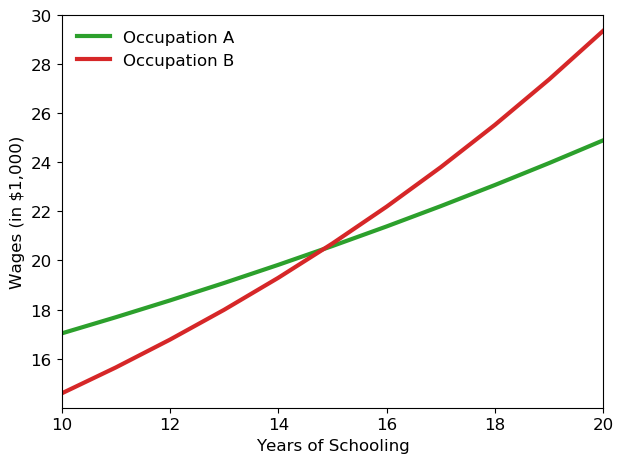

In [9]:
fig

## Replication - Effect of college tuition subsidy

This section replicates Table 6 in Keane and Wolpin (1994) which studies the effect of different amounts of tuition subsidies. First, we are going to show the effect of the tuition subsidy on each of the parametrizations for a sample of 1,000 simulated individuals. After that, Table 6 is replicated where the policy effect is measured as the average difference in experience for 40 samples with 100 invididuals with and without the tutition subsidy. The authors apply a 500 USD tuition subsidy on the first parametrization, 1,000 USD on the second and 2,000 USD on the third parametrization.

The following figures show the impact of the tuition subsidies for each of the parametrizations next to each other.

In [10]:
# Build simulate function as only parameters change, it can be reused.
params, options, _ = rp.get_example_model("kw_94_one")
options["simulation_agents"] = 4_000
simulate = rp.get_simulate_func(params, options)

models = np.repeat(["one", "two", "three"], 2)
tuition_subsidies = [0, 500, 0, 1_000, 0, 2_000]

data_frames = []

for model, tuition_subsidy in zip(models, tuition_subsidies):
    params, _, _ = rp.get_example_model(f"kw_94_{model}")
    params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] += tuition_subsidy
    data_frames.append(simulate(params))

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), sharey=True, sharex=True)

axs = axs.flatten()

for df, ax, model, tuition_subsidy in zip(data_frames, axs, models, tuition_subsidies):
    shares = (
        df.groupby("Period")
        .Choice.value_counts(normalize=True)
        .unstack()[["home", "edu", "a", "b"]]
    )

    shares.plot.bar(stacked=True, ax=ax, width=1, legend=True)

    ax.set_ylim(0, 1)
    ax.set_xticks(range(0, 40, 5))
    ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")
    ax.set_ylabel("Share of population")
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if tuition_subsidy:
        label = f"with a tuition subsidy of {tuition_subsidy:,} USD"
    else:
        label = "without a tuition subsidy"
    ax.set_title(f"Parameterization {model.title()} \n {label}")

fig.legend(
    handles,
    ["Home", "Education", "A", "B"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=4,
);

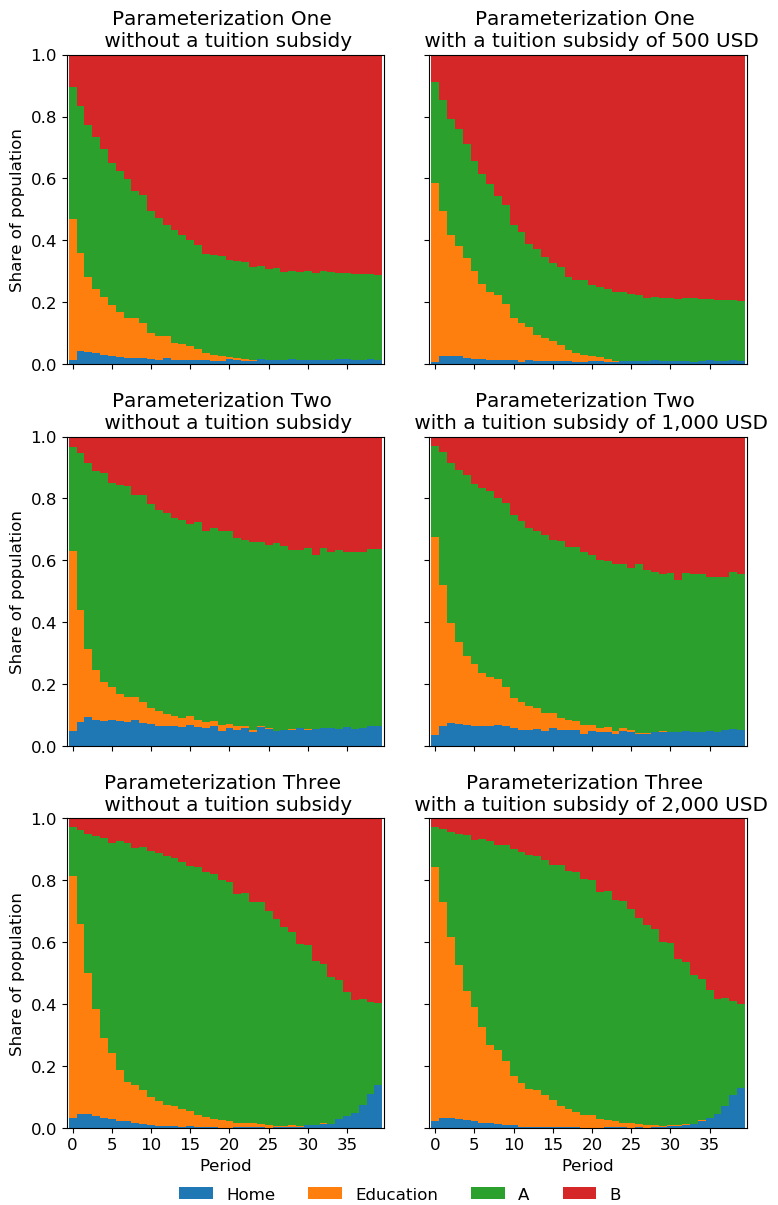

In [12]:
fig

In [13]:
columns = [
    "Bootstrap_Sample",
    "Experience_Edu",
    "Experience_A",
    "Experience_B",
]
parameterizations = ["Data Set One", "Data Set Two", "Data Set Three"]
bootstrapped_statistics = []

for i, title in zip(range(0, 6, 2), parameterizations):
    # Select sample with and without tuition subsidy.
    df_wo_ts = data_frames[i]
    df_w_ts = data_frames[i + 1]

    # Assign bootstrap sample number.
    df_wo_ts["Bootstrap_Sample"] = pd.cut(
        df_wo_ts.Identifier, bins=40, labels=np.arange(1, 41)
    )
    df_w_ts["Bootstrap_Sample"] = pd.cut(
        df_w_ts.Identifier, bins=40, labels=np.arange(1, 41)
    )

    # Calculate mean experiences.
    mean_exp_wo_ts = (
        df_wo_ts.loc[df_wo_ts.Period.eq(39), columns].groupby("Bootstrap_Sample").mean()
    )
    mean_exp_w_ts = (
        df_w_ts.loc[df_w_ts.Period.eq(39), columns].groupby("Bootstrap_Sample").mean()
    )

    mean_exp_wo_ts = (
        df_wo_ts.loc[
            df_wo_ts.Period.eq(39),
            ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B",],
        ]
        .groupby("Bootstrap_Sample")
        .mean()
    )
    mean_exp_w_ts = (
        df_w_ts.loc[
            df_w_ts.Period.eq(39),
            ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B",],
        ]
        .groupby("Bootstrap_Sample")
        .mean()
    )

    # Calculate bootstrap statistics.
    diff = (
        mean_exp_w_ts.subtract(mean_exp_wo_ts)
        .assign(Data=title)
        .reset_index()
        .set_index(["Data", "Bootstrap_Sample"])
        .stack()
        .unstack([0, 2])
    )
    bootstrapped_statistics.append(diff)

replication = pd.concat(
    [bs.agg(["mean", "std"]) for bs in bootstrapped_statistics], axis=1
).round(3)
replication.columns = [
    replication.columns.get_level_values(0),
    ["edu", "a", "b"] * 3,
]
replication.index = ["Exact Solution - Mean", "Exact Solution - Std"]

The following two tables refer to summary statistics of the tuition subsidy experiment. The first table refers to the replication and the second contains the results from Keane and Wolpin (1994). The tables show the differences in experience between the sample without and with subsidy for all parameterizations. The standard deviations of the mean are computed by simulating 40 bootstrap samples á 100 individuals. All means of the replication lie within one standard deviation.

In [14]:
replication

Data Set One               Data Set Two                \
                               edu      a      b          edu      a      b   
Exact Solution - Mean        1.449 -3.450  2.213        1.116 -2.685  2.004   
Exact Solution - Std         0.217  0.987  0.887        0.236  0.622  0.516   

                      Data Set Three                
                                 edu      a      b  
Exact Solution - Mean          1.693 -1.349 -0.212  
Exact Solution - Std           0.226  0.242  0.111

In [15]:
table_6 = pd.read_csv(
    rp.config.TEST_RESOURCES_DIR / "kw_94_table_6.csv", nrows=2, header=1, index_col=0,
)
table_6.columns = [np.repeat(parameterizations, 3), ["edu", "a", "b"] * 3]

In [16]:
table_6

Data Set One             Data Set Two              \
                               edu     a     b          edu     a     b   
Exact Solution - Mean         1.44 -3.43  2.19         1.12 -2.71  2.08   
Exact Solution - Std          0.18  0.94  0.89         0.22  0.53  0.43   

                      Data Set Three               
                                 edu     a      b  
Exact Solution - Mean           1.67 -1.27 -0.236  
Exact Solution - Std            0.20  0.18  0.100

## Replication - Choice distributions

This section replicates the choice distributions for all three parameterizations in Keane and Wolpin (1994b) Table 2.1-2.3. The tables show the share of individuals choosing each choice for each period. The original results are on the left hand side and the replications on the right hand side.

In [17]:
params, options, df = rp.get_example_model("kw_94_one")

table_2_1 = pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_1.csv").drop(
    columns="period"
)
table_2_1.columns = [["Table 2.1"] * 4, table_2_1.columns]

repl = (
    df.groupby("Period")
    .Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_1 = pd.concat([table_2_1, repl], axis=1)
table_2_1.index.name = "Period"

In [18]:
table_2_1

Table 2.1                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.386  0.116  0.490  0.008       0.442  0.093  0.453  0.012
1          0.427  0.175  0.354  0.044       0.474  0.184  0.293  0.049
2          0.444  0.220  0.308  0.028       0.490  0.228  0.244  0.038
3          0.459  0.263  0.255  0.023       0.473  0.261  0.227  0.039
4          0.417  0.332  0.218  0.033       0.473  0.292  0.197  0.038
5          0.427  0.374  0.175  0.024       0.467  0.337  0.171  0.025
6          0.412  0.387  0.179  0.022       0.457  0.361  0.165  0.017
7          0.399  0.421  0.155  0.025       0.419  0.407  0.153  0.021
8          0.372  0.475  0.130  0.023       0.421  0.428  0.133  0.018
9          0.355  0.501  0.126  0.018       0.415  0.456  0.107  0.022
10         0.340  0.537  0.099  0.024       0.416  0.492  0.076  0.016
11         0.342  0.567  0.081  0.010       0.379  0.534  0.070  0.017
12         0.322  0.585  0.073  0.020       0.385  0.532  0.064  0.019
13         0.321  0.612  0.056  0.011       0.374  0.568  0.047  0.011
14         0.303  0.619  0.062  0.016       0.349  0.586  0.045  0.020
15         0.297  0.640  0.052  0.011       0.358  0.593  0.039  0.010
16         0.290  0.664  0.034  0.012       0.346  0.601  0.039  0.014
17         0.304  0.656  0.028  0.012       0.339  0.623  0.026  0.012
18         0.283  0.686  0.018  0.013       0.324  0.652  0.017  0.007
19         0.277  0.695  0.016  0.012       0.314  0.655  0.012  0.019
20         0.288  0.691  0.011  0.010       0.316  0.663  0.005  0.016
21         0.266  0.716  0.003  0.015       0.308  0.667  0.009  0.016
22         0.268  0.717  0.006  0.009       0.318  0.668  0.006  0.008
23         0.258  0.731  0.001  0.010       0.305  0.678  0.003  0.014
24         0.265  0.715  0.005  0.015       0.306  0.683  0.000  0.011
25         0.270  0.720  0.003  0.007       0.304  0.677  0.001  0.018
26         0.254  0.730  0.000  0.016       0.298  0.691  0.001  0.010
27         0.252  0.743  0.000  0.005       0.303  0.679  0.000  0.018
28         0.249  0.736  0.000  0.015       0.307  0.683  0.000  0.010
29         0.241  0.742  0.000  0.017       0.288  0.698  0.000  0.014
30         0.246  0.743  0.000  0.011       0.289  0.699  0.000  0.012
31         0.243  0.750  0.000  0.007       0.302  0.686  0.000  0.012
32         0.242  0.748  0.000  0.010       0.288  0.694  0.000  0.018
33         0.243  0.746  0.000  0.011       0.282  0.706  0.000  0.012
34         0.229  0.757  0.000  0.014       0.282  0.704  0.000  0.014
35         0.244  0.750  0.000  0.006       0.279  0.703  0.000  0.018
36         0.234  0.755  0.000  0.011       0.278  0.702  0.000  0.020
37         0.238  0.749  0.000  0.013       0.278  0.704  0.000  0.018
38         0.231  0.753  0.000  0.016       0.278  0.710  0.000  0.012
39         0.230  0.758  0.000  0.012       0.274  0.708  0.000  0.018

In [19]:
params, options, df = rp.get_example_model("kw_94_two")

table_2_2 = pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_2.csv").drop(
    columns="period"
)
table_2_2.columns = [["Table 2.2"] * 4, table_2_2.columns]

repl = (
    df.groupby("Period")
    .Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_2 = pd.concat([table_2_2, repl], axis=1)
table_2_2.index.name = "Period"

In [20]:
table_2_2

Table 2.2                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.344  0.038  0.575  0.043       0.304  0.033  0.616  0.047
1          0.481  0.059  0.375  0.085       0.460  0.067  0.401  0.072
2          0.606  0.073  0.238  0.083       0.582  0.094  0.232  0.092
3          0.633  0.115  0.176  0.076       0.600  0.125  0.174  0.101
4          0.658  0.126  0.143  0.073       0.632  0.117  0.161  0.090
5          0.659  0.146  0.111  0.084       0.625  0.151  0.158  0.066
6          0.662  0.151  0.096  0.091       0.628  0.174  0.128  0.070
7          0.642  0.182  0.097  0.079       0.621  0.174  0.125  0.080
8          0.657  0.174  0.084  0.085       0.614  0.212  0.092  0.082
9          0.632  0.210  0.082  0.076       0.657  0.214  0.065  0.064
10         0.648  0.227  0.056  0.069       0.650  0.236  0.050  0.064
11         0.642  0.241  0.046  0.071       0.632  0.264  0.044  0.060
12         0.641  0.254  0.044  0.061       0.629  0.269  0.041  0.061
13         0.643  0.265  0.036  0.056       0.627  0.279  0.045  0.049
14         0.633  0.278  0.029  0.060       0.626  0.272  0.046  0.056
15         0.625  0.291  0.023  0.061       0.610  0.304  0.031  0.055
16         0.623  0.305  0.020  0.052       0.643  0.282  0.026  0.049
17         0.628  0.289  0.028  0.055       0.613  0.300  0.026  0.061
18         0.599  0.325  0.014  0.062       0.625  0.292  0.021  0.062
19         0.597  0.322  0.020  0.061       0.590  0.330  0.014  0.066
20         0.621  0.317  0.017  0.045       0.594  0.355  0.006  0.045
21         0.613  0.327  0.010  0.050       0.562  0.372  0.011  0.055
22         0.585  0.358  0.006  0.051       0.577  0.359  0.006  0.058
23         0.580  0.360  0.005  0.055       0.545  0.390  0.004  0.061
24         0.596  0.344  0.000  0.060       0.573  0.375  0.001  0.051
25         0.622  0.334  0.003  0.041       0.583  0.370  0.004  0.043
26         0.566  0.376  0.002  0.056       0.553  0.381  0.005  0.061
27         0.567  0.386  0.001  0.046       0.565  0.365  0.002  0.068
28         0.548  0.394  0.000  0.058       0.584  0.370  0.000  0.046
29         0.560  0.373  0.002  0.065       0.552  0.387  0.000  0.061
30         0.562  0.374  0.000  0.064       0.548  0.398  0.000  0.054
31         0.568  0.388  0.000  0.044       0.544  0.394  0.000  0.062
32         0.562  0.374  0.000  0.064       0.554  0.387  0.000  0.059
33         0.569  0.367  0.000  0.064       0.540  0.397  0.000  0.063
34         0.578  0.369  0.000  0.053       0.536  0.407  0.000  0.057
35         0.557  0.390  0.000  0.053       0.541  0.395  0.000  0.064
36         0.562  0.387  0.000  0.051       0.545  0.400  0.000  0.055
37         0.542  0.397  0.000  0.061       0.561  0.376  0.000  0.063
38         0.562  0.385  0.000  0.053       0.555  0.387  0.000  0.058
39         0.551  0.390  0.000  0.059       0.569  0.380  0.000  0.051

In [21]:
params, options, df = rp.get_example_model("kw_94_three")

table_2_3 = pd.read_csv(rp.config.TEST_RESOURCES_DIR / "kw_94_wp_table_2_3.csv").drop(
    columns="period"
)
table_2_3.columns = [["Table 2.3"] * 4, table_2_3.columns]

repl = (
    df.groupby("Period")
    .Choice.value_counts(normalize=True)
    .unstack("Choice")
    .fillna(0)
    .round(3)
)
repl.columns = [["Replication"] * 4, repl.columns]

table_2_3 = pd.concat([table_2_3, repl], axis=1)
table_2_3.index.name = "Period"

In [22]:
table_2_3

Table 2.3                      Replication                     
               a      b    edu   home           a      b    edu   home
Period                                                                
0          0.169  0.036  0.752  0.043       0.153  0.028  0.769  0.050
1          0.308  0.042  0.594  0.056       0.315  0.048  0.585  0.052
2          0.455  0.058  0.430  0.057       0.463  0.054  0.418  0.065
3          0.574  0.066  0.326  0.034       0.544  0.067  0.321  0.068
4          0.628  0.070  0.255  0.047       0.631  0.064  0.258  0.047
5          0.710  0.071  0.189  0.030       0.682  0.076  0.200  0.042
6          0.725  0.080  0.166  0.029       0.741  0.076  0.156  0.027
7          0.746  0.090  0.139  0.025       0.760  0.077  0.124  0.039
8          0.752  0.090  0.132  0.026       0.758  0.103  0.111  0.028
9          0.762  0.101  0.123  0.014       0.795  0.103  0.081  0.021
10         0.782  0.115  0.083  0.020       0.816  0.107  0.063  0.014
11         0.797  0.120  0.071  0.012       0.788  0.129  0.069  0.014
12         0.793  0.129  0.070  0.008       0.799  0.127  0.065  0.009
13         0.782  0.153  0.059  0.006       0.808  0.123  0.056  0.013
14         0.788  0.148  0.055  0.009       0.801  0.144  0.047  0.008
15         0.779  0.158  0.054  0.009       0.787  0.162  0.045  0.006
16         0.783  0.173  0.042  0.002       0.790  0.167  0.035  0.008
17         0.775  0.182  0.035  0.008       0.771  0.183  0.037  0.009
18         0.776  0.192  0.029  0.003       0.773  0.183  0.037  0.007
19         0.763  0.208  0.028  0.001       0.757  0.208  0.028  0.007
20         0.757  0.218  0.022  0.003       0.754  0.224  0.019  0.003
21         0.740  0.235  0.020  0.005       0.735  0.246  0.015  0.004
22         0.704  0.280  0.014  0.002       0.709  0.278  0.010  0.003
23         0.712  0.274  0.012  0.002       0.708  0.280  0.009  0.003
24         0.712  0.269  0.013  0.006       0.703  0.282  0.010  0.005
25         0.698  0.290  0.008  0.004       0.645  0.335  0.011  0.009
26         0.657  0.332  0.004  0.007       0.646  0.342  0.008  0.004
27         0.625  0.368  0.003  0.004       0.630  0.357  0.006  0.007
28         0.628  0.369  0.001  0.002       0.617  0.376  0.002  0.005
29         0.587  0.396  0.004  0.013       0.595  0.395  0.003  0.007
30         0.557  0.433  0.001  0.009       0.549  0.430  0.001  0.020
31         0.541  0.452  0.000  0.007       0.525  0.454  0.002  0.019
32         0.516  0.468  0.000  0.016       0.512  0.467  0.002  0.019
33         0.494  0.484  0.001  0.021       0.456  0.512  0.000  0.032
34         0.445  0.518  0.000  0.037       0.425  0.533  0.000  0.042
35         0.388  0.571  0.000  0.041       0.393  0.557  0.000  0.050
36         0.370  0.575  0.001  0.054       0.350  0.579  0.000  0.071
37         0.329  0.584  0.000  0.087       0.345  0.560  0.000  0.095
38         0.306  0.595  0.000  0.099       0.304  0.592  0.000  0.104
39         0.270  0.604  0.000  0.126       0.283  0.569  0.000  0.148

## References

> Keane, M. P. and  Wolpin, K. I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://doi.org/10.2307/2109768). *The Review of Economics and Statistics*, 76(4): 648-672.

> Keane, M. P. and  Wolpin, K. I. (1994b). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://www.minneapolisfed.org/research/staff-reports/the-solution-and-estimation-of-discrete-choice-dynamic-programming-models-by-simulation-and-interpolation-monte-carlo-evidence). *Federal Reserve Bank of Minneapolis*, No. 181.